In [1]:
%load_ext autoreload

In [24]:
%autoreload

import numpy as np
from numpy.linalg import multi_dot
import matplotlib
import matplotlib.pyplot as plt
from astropy.io import fits
import scipy
from scipy.interpolate import interp1d
import math as m
import scipy.constants as p
import pandas as pd
import matplotlib.pyplot as plt
import timeit
import sys
sys.path.append("..")
import physics
sys.path.append("../..")
from spec.spectrum import *
import spec.spectools as spectools
#%run 'Electrons_v1.ipynb' might need things form this later
import xsecs
np.set_printoptions(precision=20)

In [134]:
class Rates(object):
    '''
    Allows for easier storage of all xsecs/rates (probabilities)
    Made specifically for ion and heating ONLY.
    
    Attributes
    -----------
    E_spec : Spectrum class
        Electron energy and dNdE spectrum
    n : int
        The bin of interest in the spectrum
    den : ndarray
        density of [H, He, He+] in cm^-3
    rates : ndarray
        dN/dt; Filled with various rates in s^-1
    dNdW : ndarray
        ()()()
    '''
    
    def __init__(self, E_spec, n, den=[1,1,1], dNdW=np.zeros((2,1)), rates=np.zeros(4)):
        '''Return a Rate object with electron of energy *E_spec.eng[n]*
        in a universe with densities *den*; initializes *rate* vector'''
        self.energy = E_spec.eng[n]
        self.n = n
        self.dNdE = E_spec.dNdE[n]
        self.den = den
        self.rates = rates
        self.v = np.sqrt(2*np.array([E_spec.eng[n]])/physics.me)*physics.c 
        self.mult = self.den*self.v
        self.dNdW = np.zeros((2, self.n -1))
    
    def ion_dNdW_calc_H(self): #uses new integration method
        '''Fills *self.dNdW[0,:]* with the discretized singly differential xsec in rate form
        '''
        eng_temp = E_spec.eng[0:self.n-1]
        ion_s_rates = xsecs.ionize_s_cs_H(self.energy, eng_temp) #possible problem with np type
        self.dNdW[0] = ion_s_rates *self.mult[0] #dNdE?
        return self.dNdW
    
    def ion_rate_calc(self):
        '''Fills *self.rate[1:3]* vector by calculating total xsec and then converting to rate
        '''
        ion_rates = xsecs.ionize_cs(self.energy*np.ones(3),np.array([1,2,3]))*self.mult
        self.rates[1:4] = ion_rates
        return self.rates
    
    def heat_rate_calc(self, x_e, rs):
        '''Fills *self.rate[0]* vector with fraction going to heating
            x_e and rs...
        '''
        dE = xsecs.heating_dE(self.energy, x_e, rs, nH=physics.nH)
        delta_dNdE = np.zeros(len(E_spec.dNdE))
        np.put(delta_dNdE, self.n, self.dNdE)
        delta = Spectrum(E_spec.eng, delta_dNdE, rs)
        shift_delta_eng = E_spec.eng+dE
        delta.shift_eng(shift_delta_eng)
        delta.rebin(E_spec.eng)
        
        heating_frac = delta.dNdE[self.n]/self.dNdE
        self.rates[0] = 1-heating_frac
        return(self.rates)
    def tot_sum(self):
        '''Sums all elements of rate
        '''
        tot_sum = sum(self.rates)
        return tot_sum
    def con_prob(self):
        '''Finds cumulative probability of each process
        '''
        con_prob = self.rates/self.tot_sum()
        return con_prob
    def E_loss(self):
        '''loss fraction
        '''
        E_loss_ion=13.6*self.rates[1]
        E_loss_heat=(E_spec.eng[self.n]-E_spec.eng[self.n-1])*self.rates[0]
        E_frac = E_loss_ion/E_loss_heat
        return(E_frac)
    def ion_int_calc(self):
        '''gives total ionization rate
        '''
        bin_width = get_log_bin_width(E_spec.eng[0:self.n])
        integ = 0
        for i in range(self.n):
            integ += self.dNdW[0,i-1]*bin_width[i]*E_spec.eng[i]
        return integ
        
        

In [5]:
eng1 = np.logspace(0.,4.,num = 500)
dNdE1 = np.logspace(0.,5.,num = 500)
rs=1000
E_spec = Spectrum(eng1,dNdE1,rs)
photon_spec = Spectrum(E_spec.eng,np.zeros(len(E_spec.eng)),rs)
TM=np.zeros([len(photon_spec.eng)+2,len(E_spec.eng)]) #possibly make pandas
Transfer_Matrix=pd.DataFrame(TM) #or np.zeros
#print(Transfer_Matrix)
print(np.array([E_spec.eng[330]]))
print(xsecs.ionize_cs(np.array([E_spec.eng[100]]),np.ones(1)))

[ 441.86599563859414274702]
[ 0.]


In [23]:
a = Rates(E_spec, 300)
# print(a.dNdW)
#a.ion_dNdW_calc_H()
#print(a.dNdW[0])
#print(a.ion_int_calc())
#print(a.energy)
#print(a.ion_rate_calc())
# print(a.heat_rate_calc(0.0001, 300))
# print(a.tot_sum())
# print(a.con_prob())
# print(a.rates)


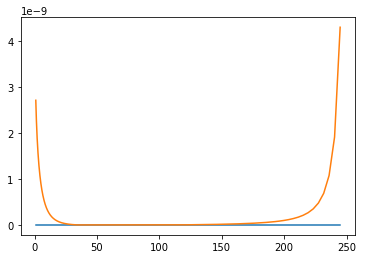

In [11]:
x_test = E_spec.eng[0:299]
y_test_1 = a.dNdW[0]
y_test_2 = xsecs.ionize_s_cs(E_spec.eng[300]*np.ones(299),x_test,np.ones(299))*a.mult[0]
plt.plot(x_test, y_test_1)
plt.plot(x_test, y_test_2)
plt.show()

In [135]:
def electron_low_e(E_spec, rs, ion_frac=[10**-4,10**-4,10**-4], den=[1,1,1], dt=1, photon_abscissa=E_spec.eng ,all_outputs=False):
    '''
    Finds transfer matrix for a given initial electron spectrum
    Outputs: photon spectrum, transfer matrix, E_loss to each process
    '''
    
    N = len(E_spec.eng)
    #initialize rate-loss array such that initially, all rates go to heating
    R = np.zeros((2,N))
    R[1,0] = 1
    R[1,1] = 1
    R[1,2] = 1
    
    
    #Initialize photon spectrum (change from current pre-set when important)
    #photon_spec = Spectrum(photon_abscissa,np.zeros(len(E_spec.eng)),rs)
    
    #calculate non-ionized atomic densities
    den[0]=(physics.nH*(1-ion_frac[0]))*(rs)**3
    den[1]=(physics.nHe*(1-ion_frac[1])*(1-ion_frac[2]))*(rs)**3
    den[2]=(physics.nHe*(1-ion_frac[1])*(ion_frac[2]))*(rs)**3 #unsure about how ionfrac works for helium
    

    
    
    for n in range(3,N):
        e_rates = Rates(E_spec, n, den)
        e_rates.ion_rate_calc()
        e_rates.heat_rate_calc(ion_frac[1], rs)
        e_rates.ion_dNdW_calc_H()
        
        #possibly evaluate outside loop
        discrete_dN_dEdt_i = e_rates.dNdW[0]
        
        h_init=np.zeros(n-1)
        h_init[n-2] = e_rates.rates[0]
        discrete_dN_dEdt_h = h_init
        
        delta_E_spec = np.ediff1d(E_spec.eng)[0:(n-1)] #bin widths
 
        
        R[0,n] = ((13.6*e_rates.rates[1]) + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i*R[0,0:n-1]*delta_E_spec) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h*R[0,0:n-1]*delta_E_spec))/e_rates.energy
        
        
        R[1,n] = ((e_rates.energy*e_rates.rates[0]-np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h*delta_E_spec)) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_i*R[1,0:n-1]*delta_E_spec) \
            + np.sum(E_spec.eng[0:n-1]*discrete_dN_dEdt_h*R[1,0:n-1]*delta_E_spec))/e_rates.energy

    return R
    

In [136]:
%%time
electron_low_e(E_spec,100)

CPU times: user 17.1 s, sys: 427 ms, total: 17.5 s
Wall time: 18.9 s


array([[  0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.00000000000000000000e+00,
          0.00000000000000000000e+00,   0.000000